In [95]:
import os, json, numpy as np, pickle, rdkit, tqdm
from rdkit import Chem
from matplotlib import pyplot as plt


In [2]:
!cp /data/data/colin_split_05_23_22.zip ../tempdata

In [3]:
!unzip ../tempdata/colin_split_05_23_22.zip -d ../tempdata -q

Archive:  ../tempdata/colin_split_05_23_22.zip
   creating: ../tempdata/data/
   creating: ../tempdata/data/hsqc_ms_pairs/
  inflating: ../tempdata/data/hsqc_ms_pairs/train.pkl  
  inflating: ../tempdata/data/hsqc_ms_pairs/val.pkl  
  inflating: ../tempdata/data/hsqc_ms_pairs/test.pkl  
  inflating: ../tempdata/data/.DS_Store  
   creating: ../tempdata/data/hsqc_pretrain/
  inflating: ../tempdata/data/hsqc_pretrain/train.pkl  
  inflating: ../tempdata/data/hsqc_pretrain/val.pkl  
  inflating: ../tempdata/data/hsqc_pretrain/test.pkl  
   creating: ../tempdata/data/ms_pretrain/
  inflating: ../tempdata/data/ms_pretrain/train.pkl  
  inflating: ../tempdata/data/ms_pretrain/val.pkl  
  inflating: ../tempdata/data/ms_pretrain/test.pkl  


In [81]:
pairs = "../tempdata/data"
dirs = ["hsqc_ms_pairs", "hsqc_pretrain"]
dic = {}
for dir in dirs:
    path = os.path.join(pairs, dir)
    for fi in os.listdir(path):
        with open(f"../tempdata/data/{dir}/{fi}", "rb") as fp:
            my_file = pickle.load(fp)
        dic[f"{dir}{fi}"] = my_file

In [79]:
def get_canonical(smiles_orig):
    mol = Chem.MolFromSmiles(smiles_orig)
    smiles = Chem.MolToSmiles(mol, False) if mol is not None else None
    return smiles
example_sm = "../tempdata/data/train/smiles/CCMSLIB00000079525.npy"
example_hsqc = "../tempdata/data/train/HSQC_2ch/CCMSLIB00000079525.npy"
loaded_sm = str(np.load(example_sm))
loaded_hsqc = np.load(example_hsqc)
loaded_sm_canon = get_canonical(loaded_sm)
print(loaded_sm, loaded_sm_canon)

Nc1cc2nc3ccccc3oc2cc1=O Nc1cc2nc3ccccc3oc-2cc1=O


In [82]:
print(f"Keys: {dic.keys()}")
keys = ['HSQC', 'MS', 'FP', 'SMILES', 'NAMES']
my_max = [-np.inf, -np.inf, -np.inf]
my_min = [np.inf, np.inf, np.inf]
for k, v in dic.items():
    print(f"=== {k} ===")
    for k2, v2 in v.items():
        maxes = np.max(v2["HSQC"], axis=0)
        mins = np.min(v2["HSQC"], axis=0)
        my_max = np.max(np.stack((my_max, maxes), axis=0), axis=0)
        my_min = np.min(np.stack((my_min, mins), axis=0), axis=0)
        if v2["SMILES"] == loaded_sm_canon:
            print(k, k2)
        
print(my_max, my_min)

Keys: dict_keys(['hsqc_ms_pairstrain.pkl', 'hsqc_ms_pairsval.pkl', 'hsqc_ms_pairstest.pkl', 'hsqc_pretraintrain.pkl', 'hsqc_pretrainval.pkl', 'hsqc_pretraintest.pkl'])
=== hsqc_ms_pairstrain.pkl ===
=== hsqc_ms_pairsval.pkl ===
=== hsqc_ms_pairstest.pkl ===
hsqc_ms_pairstest.pkl 8411
=== hsqc_pretraintrain.pkl ===
hsqc_pretraintrain.pkl 50197
hsqc_pretraintrain.pkl 50198
=== hsqc_pretrainval.pkl ===
=== hsqc_pretraintest.pkl ===
[2.26250000e+02 1.27500000e+01 3.63865375e+05] [-1.40350006e+02 -8.36666584e-01 -7.02454312e+05]


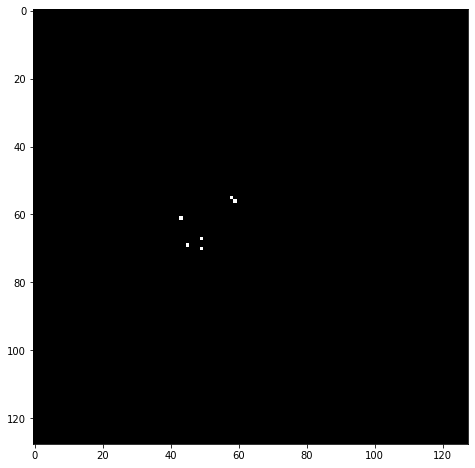

(array([55, 56, 61, 67, 69, 70]), array([58, 59, 43, 49, 45, 49]), array([0, 0, 0, 0, 0, 0]))


In [59]:
def plot(my_hsqc):
    my_hsqc_2 = np.concatenate((my_hsqc, np.zeros((128, 128, 1))), axis=2)
    my_hsqc_2[:,:,1] = my_hsqc_2[:,:,0]
    my_hsqc_2[:,:,2] = my_hsqc_2[:,:,0]
    fig, ax = plt.figure(figsize=(8, 8)), plt.axes()
    ax = fig.axes[0]
    ax.imshow(my_hsqc_2)
    plt.show()
    print(np.nonzero(my_hsqc))
plot(loaded_hsqc)

['226.250000', '12.750000', '363865.375000'] ['-140.350000', '-0.837000', '-702454.312000']


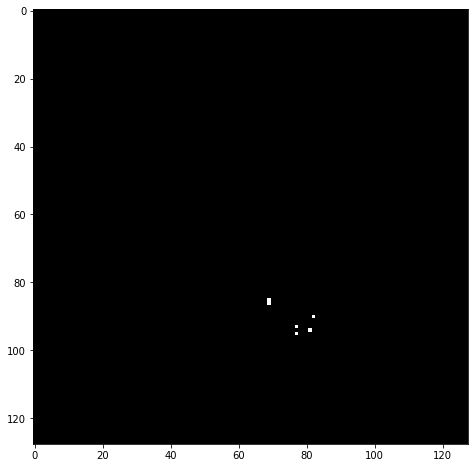

(array([85, 86, 90, 93, 94, 95]), array([69, 69, 82, 77, 81, 77]), array([0, 0, 0, 0, 0, 0]))


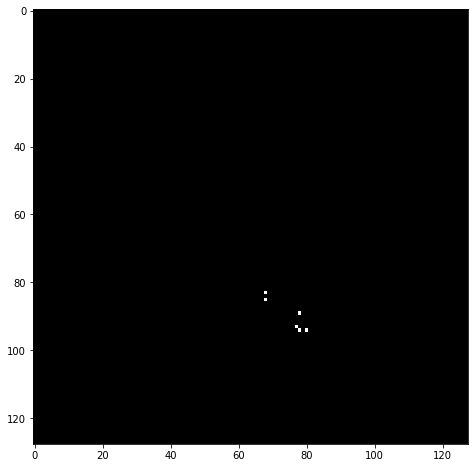

(array([83, 85, 89, 93, 94, 94]), array([68, 68, 78, 77, 78, 80]), array([0, 0, 0, 0, 0, 0]))


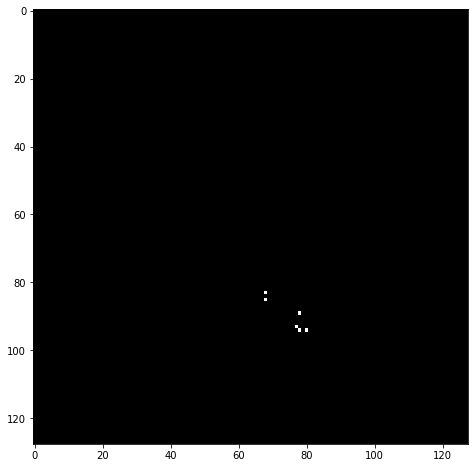

(array([83, 85, 89, 93, 94, 94]), array([68, 68, 78, 77, 78, 80]), array([0, 0, 0, 0, 0, 0]))


In [94]:
# test.pkl 8411
# [2.10119995e+02 1.14187155e+01 1.62944672e+05] [-1.14399996e+01 -8.36666584e-01 -2.63618469e+05]
hi, lo = my_max, my_min
hi2, lo2 = np.round(hi, 3), np.round(lo, 3)
print([f"{v:2f}" for v in hi2], [f"{v:2f}" for v in lo2])
my_things = [("hsqc_pretraintrain.pkl",50197), ("hsqc_pretraintrain.pkl",50198), ("hsqc_ms_pairstest.pkl",8411)]

def process(my_hsqc):
    new_hsqc = (my_hsqc - lo)/(hi - lo)*128
    img = np.zeros((128, 128, 2))
    for x,y,z in new_hsqc:
        x,y = int(np.clip(np.round(x), 0, 127)), int(np.clip(np.round(y), 0, 127))
        z = 0 if z >= 0 else 1
        img[x,y,z] = 1
    return img

for k, id in my_things:
    paired_sample = dic[k][id]
    hsqc_img = process(paired_sample["HSQC"])
    plot(hsqc_img)

In [101]:
keys = ["hsqc_ms_pairstrain.pkl", "hsqc_ms_pairsval.pkl", "hsqc_ms_pairstest.pkl"]
out_path = "../tempdata/new_split"
outs = ["train", "val", "test"]
dir_subnames = ["HSQC_2ch", "mass_spec_scaled", "fingerprint"]
for k,o in zip(keys, outs):
    items = dic[k]
    join_path = os.path.join(out_path, o)
    os.makedirs(join_path, exist_ok=True)
    for subdir in dir_subnames:
        os.makedirs(os.path.join(join_path, subdir), exist_ok=True)
    for k2, v2 in tqdm.tqdm(items.items()):
        name = f"mol_{k2}.npy"
        hsqc = process(v2["HSQC"])
        ms = v2["MS"]
        fp = v2["FP"]

        np.save(os.path.join(join_path, "HSQC_2ch", name), hsqc)
        np.save(os.path.join(join_path, "mass_spec_scaled", name), ms)
        np.save(os.path.join(join_path, "fingerprint", name), fp)

100%|██████████| 1224/1224 [00:01<00:00, 740.99it/s]


In [100]:
dic["hsqc_ms_pairstrain.pkl"][0]["MS"].shape

(150, 2)